In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [2]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

each line of train_set_x_orig, test_set_x_orig is an array representing an image.

(1, 209)


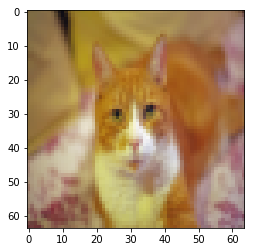

In [3]:
#function: plt.show() shows a image of (64, 64, 3)
index = 24
plt.imshow(train_set_x_orig[index])
print(train_set_y.shape)

In [4]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [5]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print(train_set_x_flatten.shape)
print(test_set_x_flatten.shape)
print(train_set_y.shape)
print(test_set_y.shape)

print(train_set_x_flatten[0:5, 0]) #row:0~5, col:0

(12288, 209)
(12288, 50)
(1, 209)
(1, 50)
[17 31 56 22 33]


In [6]:
# standardize dataset

train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

print(train_set_x.shape)
print(test_set_x.shape)

(12288, 209)
(12288, 50)


In [7]:
def sigmoid(z):
    return (1.0 / (1.0 + np.exp(-z)))

In [8]:
print("sigmoid([0, 2]) = " + str(sigmoid(np.array([0, 2]))))

sigmoid([0, 2]) = [ 0.5         0.88079708]


In [9]:
"""
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
"""
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print(w)
print(b)

[[ 0.]
 [ 0.]]
0


In [11]:
"""
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
"""
def propagate(w, b, X, Y):
    m = X.shape[1]
    
    #w~ (num_px * num_px * 3, 1)
    #b~1d
    #X~ (num_px * num_px * 3, m)
    #Y~(1, m)
    
    Z = np.dot(w.T, X) + b  #Z~(1, m)
    
    A = sigmoid(Z)          #A~(1, m)   Y~(1, m)
    
    cost = - np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A), axis = 1) / m
    
    dw = np.dot(X, (A - Y).T) / m   #dw~w
    db = np.sum((A - Y), axis = 1) / m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.99993216]
 [ 1.99980262]]
db = [ 0.49993523]
cost = 6.00006477319


In [13]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- eights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if(i % 100 == 0):
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and (i +1)% 100 == 0:
            print ("Cost after iteration %i: %f" %(i+1, cost))
    
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 1000, learning_rate = 0.009, print_cost = True)
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 100: 1.468176
Cost after iteration 200: 0.555697
Cost after iteration 300: 0.539329
Cost after iteration 400: 0.524766
Cost after iteration 500: 0.510786
Cost after iteration 600: 0.497361
Cost after iteration 700: 0.484466
Cost after iteration 800: 0.472077
Cost after iteration 900: 0.460171
Cost after iteration 1000: 0.448726
w = [[-0.98731056]
 [-0.19170416]]
b = [ 1.8978032]
dw = [[ 0.09232179]
 [-0.02386335]]
db = [-0.05809257]


In [15]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    #w = w.reshape((X.shape[0], 1))
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0][i] = 1 if A[0][i]>0.5 else 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [16]:
print ("predictions = " + str(predict(w, b, X)))

predictions = [[ 1.  1.]]


In [17]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [18]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

train accuracy: 99.043062201 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


/home/sar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


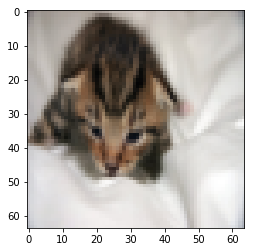

In [19]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")

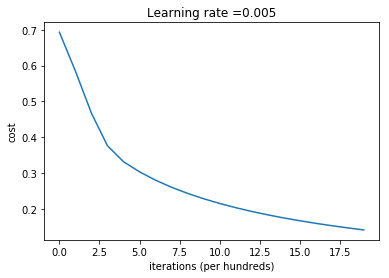

In [20]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.03
train accuracy: 100.0 %
test accuracy: 66.0 %

-------------------------------------------------------

learning rate is: 0.01
train accuracy: 99.5215311005 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.995215311 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.4210526316 %
test accuracy: 36.0 %

-------------------------------------------------------



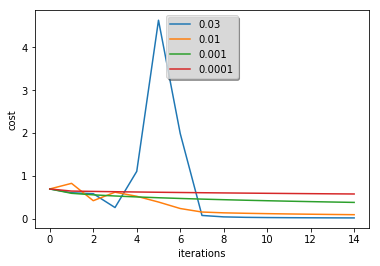

In [21]:
learning_rates = [0.03, 0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [53]:
import os
import os.path
rootdir = "/home/sar/Desktop/My_test/Python/cat_set/"
imgs = []
for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        imgs.append(rootdir + filename)
print imgs

['/home/sar/Desktop/My_test/Python/cat_set/cat-1.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-0.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-31.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-33.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-30.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-25.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-18.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-39.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-6.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-15.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-4.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-8.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-2.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-17.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-40.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-22.jpg', '/home/sar/Desktop/My_test/Python/cat_set/cat-32.jpg']


In [59]:
def test_my_set(imgs, d, num_px):
    result = []
    for my_image in imgs:
        # We preprocess the image to fit your algorithm.
        fname = my_image
        image = np.array(ndimage.imread(fname, flatten=False))
        my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
        my_predicted_image = predict(d["w"], d["b"], my_image)
        if my_predicted_image >= 0.5:
            result.append("cat")
        else:
            result.append("nocat")
    return result

In [60]:
def get_img_set(root_path):
    imgs = []
    for parent, dirnames, filenames in os.walk(rootdir):
        for filename in filenames:
            imgs.append(rootdir + filename)
    return imgs

In [66]:
root_path = "/home/sar/Desktop/My_test/Python/cat_set/"

result = test_my_set(get_img_set(root_path), d, num_px)
print result
a = 0
for label in result:
    if label == 'cat':
        a += 1
print 1.0 * a / len(result)

['cat', 'nocat', 'cat', 'cat', 'nocat', 'cat', 'cat', 'cat', 'nocat', 'cat', 'nocat', 'nocat', 'nocat', 'cat', 'nocat', 'nocat', 'cat']
0.529411764706


In [64]:
## START CODE HERE ## (PUT YOUR IMAGE NAME)
for my_image in imgs:
    
    # my_image = "dog.jpg"   # change this to the name of your image file 
    ## END CODE HERE ##
    
    # We preprocess the image to fit your algorithm.
    fname = my_image
    image = np.array(ndimage.imread(fname, flatten=False))
    print image.shape
    my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
    my_predicted_image = predict(d["w"], d["b"], my_image)

#     plt.imshow(image
    print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

(64, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(64, 64, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.
(64, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(64, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(64, 64, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.
(64, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(62, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(64, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(64, 57, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.
(64, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(64, 64, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.
(64, 64, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.
(64, 64, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.
(64, 64, 3)
y = 1.0, your algorithm predicts a "cat" picture.
(51, 64, 3)
y = 0.0, your algorithm predicts a "non-cat" picture.
(64, 64, 3)
y = 0.0, your algorithm predic